# Assignment 17
--------------------------------------------------------------------------------

In [2]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
!pip install -U -q PyDrive
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo
from colab_util import *
drive_handler = GoogleDriveHandler()

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [0]:
def Download_File_from_Drive(FileName,DriveFilepath):
  drive_handler.download(FileName, target_path=DriveFilepath)

def Upload_Images_to_Drive(FileName,TargetDrivePath):
  drive_handler.upload(FileName, parent_path=TargetDrivePath)  

In [5]:
try:
  from generate_tfrecords import CIFAR_TFRecords
  from process_tfrecords import create_Train_dataset, create_Test_dataset, parser_test, convert_to_numpy
  # from visualization import plot_image
except:
  !git clone https://github.com/santuhazra1/DEEP_LEARNING_LIBRARY.git /tmp/DEEP_LEARNING_LIBRARY
  !mv /tmp/DEEP_LEARNING_LIBRARY/TF_Records/generate_tfrecords.py generate_tfrecords.py
  !mv /tmp/DEEP_LEARNING_LIBRARY/TF_Records/process_tfrecords.py process_tfrecords.py
  # !mv /tmp/DEEP_LEARNING_LIBRARY/Visualization/visualization.py visualization.py
  !rm -r /tmp/DEEP_LEARNING_LIBRARY
  from generate_tfrecords import CIFAR_TFRecords
  from process_tfrecords import create_Train_dataset, create_Test_dataset, parser_test, convert_to_numpy
  # from visualization import plot_image

Cloning into '/tmp/DEEP_LEARNING_LIBRARY'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 59 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [6]:
try:
  Download_File_from_Drive('eval.tfrecords','EVA_Phase_1/CIFAR10_Data/eval.tfrecords')
  Download_File_from_Drive('train.tfrecords','EVA_Phase_1/CIFAR10_Data/train.tfrecords')
  print('Download Successful')
except:
  data_dir = '/content/'
  CIFAR_TFRecords(data_dir)
  Upload_Images_to_Drive('cifar-10-python.tar.gz','EVA_Phase_1/CIFAR10_Data/')
  Upload_Images_to_Drive('eval.tfrecords','EVA_Phase_1/CIFAR10_Data/')
  Upload_Images_to_Drive('train.tfrecords','EVA_Phase_1/CIFAR10_Data/')
  print('Upload Successful')

Download Successful


In [0]:
filename_train = '/content/train.tfrecords' 
filename_test = '/content/eval.tfrecords' 

In [0]:
# Hyperparameters
batch_size = 128
num_epochs = 50
num_classes = 10
l = 12
num_filter = 12
compression = 0.5
dropout_rate = 0.2
img_height = 32
img_width = 32
channel = 3

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = tf.keras.layers.BatchNormalization()(temp)
        relu = tf.keras.layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = tf.keras.layers.Conv2D(int(num_filter*2), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = tf.keras.layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = tf.keras.layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = tf.keras.layers.BatchNormalization()(input)
    relu = tf.keras.layers.Activation('relu')(BatchNorm)
    input_filter = relu.get_shape().as_list()[3]
    Conv2D_BottleNeck = tf.keras.layers.Conv2D(int(input_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = tf.keras.layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    global compression
    BatchNorm = tf.keras.layers.BatchNormalization()(input)
    relu = tf.keras.layers.Activation('relu')(BatchNorm)
    AvgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = tf.keras.layers.Flatten()(AvgPooling)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(flat)
    
    return output

input = tf.keras.layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = tf.keras.layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)            

In [10]:
model = tf.keras.models.Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
import time
# TEST TFRecords
dataset_test = create_Test_dataset(filename_test,batch_size)

sgd = tf.keras.optimizers.SGD(lr=0.005, decay=4e-5, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])
# reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
start_time = time.time()
for zz in range(1,num_epochs+1):
  dataset_train = create_Train_dataset(filename_train,batch_size)
  print("TrainEpochs number{}/{}".format(zz,num_epochs))

  model.fit_generator(dataset_train,steps_per_epoch=int(50000/batch_size),epochs=1,verbose=1,validation_data=dataset_test)#, callbacks = [reduce_lr_loss])

  # print("Test Epochs number{}/{}".format(zz,num_epochs))
  # model.evaluate_generator(dataset_test,steps=int(10000/batch_size),verbose=1)
  print("  ")
  print("------------------------",time.time()-start_time)



Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
TrainEpochs number1/50
390/390 [==============================] - 205s 525ms/step - loss: 1.6208 - acc: 0.4037 - val_loss: 2.0731 - val_acc: 0.3753
  
------------------------ 205.24196076393127
TrainEpochs number2/50
390/390 [==============================] - 199s 511ms/step - loss: 1.3158 - acc: 0.5224 - val_loss: 1.4714 - val_acc: 0.5406
  
------------------------ 404.7333092689514
TrainEpochs number3/50
390/390 [==============================] - 199s 510ms/step - lo

In [12]:
train_features, train_labels = convert_to_numpy(filename_train)
test_features, test_labels = convert_to_numpy(filename_test)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [0]:
def get_misclassified_classified_index(image_set,image_labels,model,img_class="All"):
    image_set_2 = image_set/255.0
    y_pred = model.predict(image_set_2)
    img_index_m = []
    img_index_c = []
    if img_class == "All":
        for i in range(image_set.shape[0]):
            if np.argmax(y_pred[i])!=image_labels[i]:
              img_index_m.append(i)
            else:
              img_index_c.append(i)
    else:
        for i in range(image_set.shape[0]):
            if class_names[image_labels[i]] == img_class:
                if np.argmax(y_pred[i])!=image_labels[i]:
                    img_index_m.append(i)
                else:
                    img_index_c.append(i)        
    return img_index_m, img_index_c, y_pred

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
            'dog','frog','horse','ship','truck']
# possible values of plot_type : "random", "misclassified", "classified"
def plot_image(image_set, image_labels, model, plot_type = "random", img_class = "All", num_image = 25):
    col = 5
    row = int(num_image/col)
    fig=plt.figure(figsize=(30,30))
    img_index_m, img_index_c, y_pred = get_misclassified_classified_index(image_set,image_labels,model, img_class)
    img_index = []
    img_index_2 = []
    if plot_type == "random":
        if img_class == "All":
            img_index = random.sample(range(image_set.shape[0]), k=num_image)
        else:
            for i in range(image_set.shape[0]):
                if class_names[image_labels[i]]==img_class:
                    img_index.append(i)
        for i in range(row*col):
            fig.add_subplot(row,col,i+1)
            plt.imshow(image_set[img_index[i]]) 
            plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index[i]])]), color='r')
            plt.xticks([])
            plt.yticks([])
        plt.show()

    elif plot_type == "misclassified":
        if img_class == "All":
            img_index = random.sample(img_index_m, k=num_image)
            for i in range(row*col):
                fig.add_subplot(row,col,i+1)
                plt.imshow(image_set[img_index[i]]) 
                plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index[i]])]), color='r')
                plt.xticks([])  
                plt.yticks([])
            plt.show()           
        else:
            if len(img_index_m) >= num_image:
                if len(img_index_m) > num_image:
                    img_index = random.sample(img_index_m, k=num_image)
                else:
                    img_index = img_index_m
                for i in range(row*col):
                    fig.add_subplot(row,col,i+1)
                    plt.imshow(image_set[img_index[i]]) 
                    plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index[i]])]), color='r')
                    plt.xticks([])  
                    plt.yticks([])
                plt.show() 
            else:
                if  len(img_index_m) <= 5:
                    col = len(img_index_m)
                    row = 1
                    fig=plt.figure(figsize=(10,10))
                    for i in range(row*col):
                        fig.add_subplot(row,col,i+1)
                        plt.imshow(image_set[img_index_m[i]]) 
                        plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index_m[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index_m[i]])]), color='r')
                        plt.xticks([])  
                        plt.yticks([])
                    plt.show() 
                else:
                    col = 5
                    row = int(len(img_index_m)/col)
                    fig=plt.figure(figsize=(10,10))
                    for i in range(row*col):
                        fig.add_subplot(row,col,i+1)
                        plt.imshow(image_set[img_index_m[i]]) 
                        plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index_m[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index_m[i]])]), color='r')
                        plt.xticks([])  
                        plt.yticks([])
                    plt.show()                

    elif plot_type == "classified":
        if img_class == "All":
            img_index = random.sample(img_index_c, k=num_image)
            for i in range(row*col):
                fig.add_subplot(row,col,i+1)
                plt.imshow(image_set[img_index[i]]) 
                plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index[i]])]), color='r')
                plt.xticks([])
                plt.yticks([])
            plt.show()           
        else:
            if len(img_index_c) >= num_image:
                if len(img_index_c) > num_image:
                    img_index = random.sample(img_index_c, k=num_image)
                else:
                    img_index = img_index_c
                for i in range(row*col):
                    fig.add_subplot(row,col,i+1)
                    plt.imshow(image_set[img_index[i]]) 
                    plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index[i]])]), color='r')
                    plt.xticks([])
                    plt.yticks([])
                plt.show()
            else:
                if  len(img_index_c) <= 5:
                    col = len(img_index_c)
                    row = 1
                    fig=plt.figure(figsize=(10,10))
                    for i in range(row*col):
                        fig.add_subplot(row,col,i+1)
                        plt.imshow(image_set[img_index_c[i]]) 
                        plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index_c[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index_c[i]])]), color='r')
                        plt.xticks([])  
                        plt.yticks([])
                    plt.show() 
                else:
                    col = 5
                    row = int(len(img_index_c)/col)
                    
                    for i in range(row*col):
                        fig.add_subplot(row,col,i+1)
                        plt.imshow(image_set[img_index_c[i]]) 
                        plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index_c[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index_c[i]])]), color='r')
                        plt.xticks([])  
                        plt.yticks([])
                    plt.show()
    else:
        print("wrong plot_type argument")

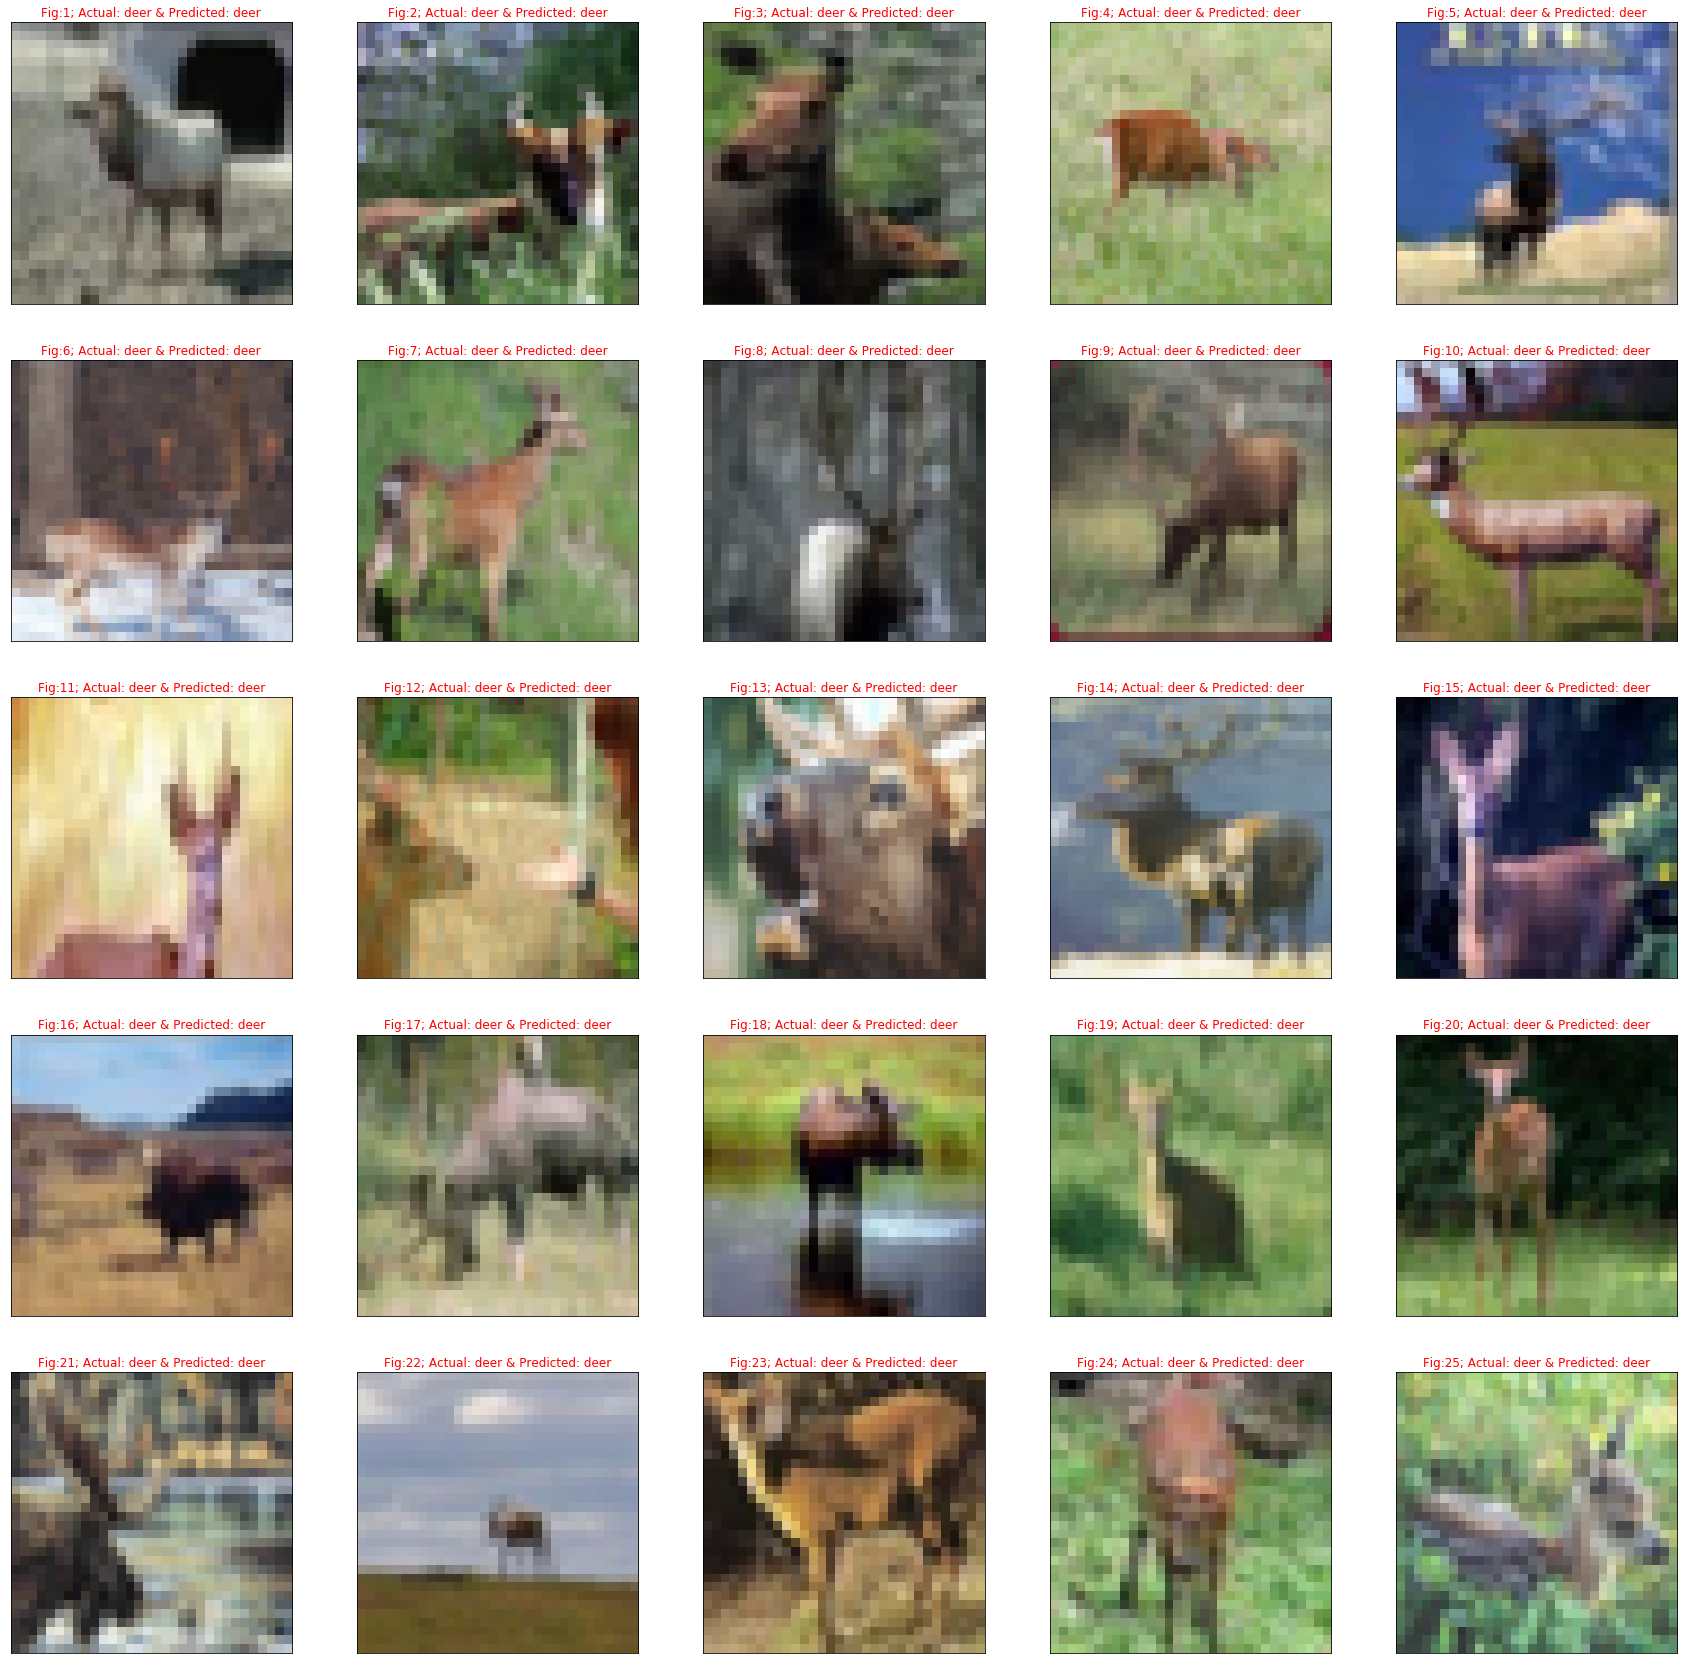

In [15]:
plot_image(test_features,test_labels,model, plot_type = "classified", img_class = "deer", num_image = 25)

In [0]:
def clear_all():
    !rm adc.json
    !rm cifar-10-python.tar.gz
    !rm colab_util.py
    !rm eval.tfrecords
    !rm generate_tfrecords.py
    !rm process_tfrecords.py
    !rm train.tfrecords
    !rm visualization.py
clear_all()    